In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

In [2]:
## Getting data
housing = pd.read_csv("Dataset/housing/housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


The boss said, given data is blocks wise (called districts) each instance is data for a district

In [3]:
print(housing.shape,"\n")
housing.info()

(20640, 10) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


- total 20640 instances (samples)  
- all features are of float type except 'ocean_proximity' (its categorical)  
- total_bedrooms possess null vlaues

In [4]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Keys to notice:
1. Total rooms/bedrooms = sum of all rooms/bedrooms in that district
2. min population of a district is 3 and max is 35600
3. the income is not in USD since it seems to low, The team told that its written after dividing actual income by 10000, i.e 3-->30000$, hence min= 38706.71$ and max= 150000$


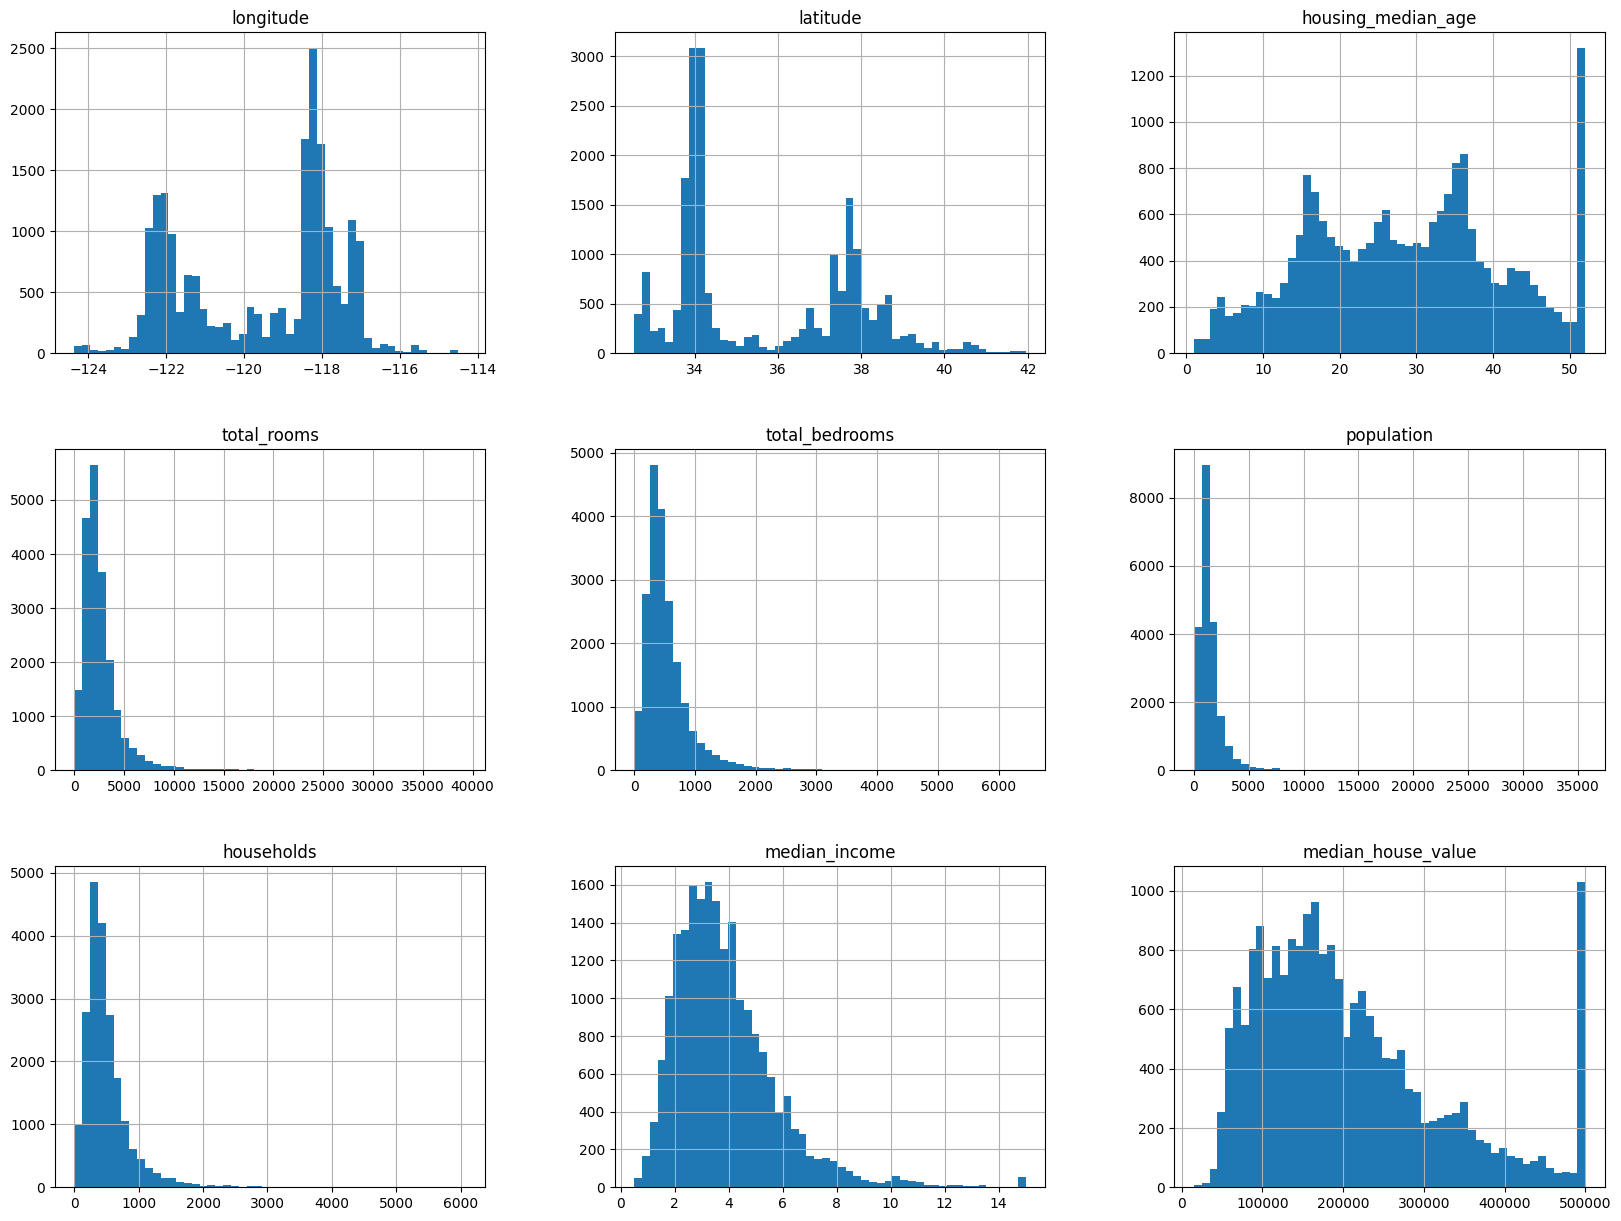

In [5]:
# plotting histplot to get insights
housing.hist(bins=50,figsize=(20,15))
plt.show()

### ___Data Snooping Bias___ : 
It occurrs when we inadverntly let insights from our data (specifically test data) to influence our model selection. 
When looking at the data(test set), and observing patterns we/our model get biased towards some patterns (subconciously), the model made based on that may be great for a subset of data but not general data, hence we voluntarily remove some data (20% for small datasets like this) and never look at it.
We do not examine on it until the final evaluation. This reserved test set then provides an unbiased estimate of our model's performance on new, unseen data.

In [6]:
len(housing.index)

20640

In [7]:
### Note: This is just for explaining, We gonna use sklearn later
## Removing 20% of data randomly

def separate_TestAndTrain(data,test_ratio):
    shuffuled_indices= np.random.permutation(data.index)     # getting a random arrangement of data.index
    test_set_size= int(len(data.index)*test_ratio)           # here, test_set_size= int(20640*0.2)= 4128.0
    test_index= shuffuled_indices[:test_set_size]            # indices for text data are from start:testsetsize
    train_index= shuffuled_indices[test_set_size:]           # indices for training data are from testsetsize:end

    return data.iloc[test_index],data.iloc[train_index]       # returns two dataframes



test_data,train_data = separate_TestAndTrain(housing,0.2)
print(len(test_data),len(train_data))

4128 16512


##### ___Splitting data into train and test data___

In [8]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(housing,test_size=0.2,random_state=42)

In [9]:
print(len(train_data))
print(len(test_data))

16512
4128


But still theres a problem....
This method also splits the data randomly, but sometimes we dont really want that.
for example, your team told you that median_income is a very important attribute to predict housing prices. Hence, now you want all kinds of median_incomes to be in your test_data to ensure a fair representation of all categories in the test data.

This is called ___`Stratified sampling`___ : dividing the data into several subgroups called `strata` and right number of instances from each stratum are sampled to ensure that test_data is representing the overall data perfectly

`Stratified Sampling` in classification problems: This method is usually for classification problems where we have an imbalanced dataset. This method samples data such that test data represent overall training data perfectly

<Axes: >

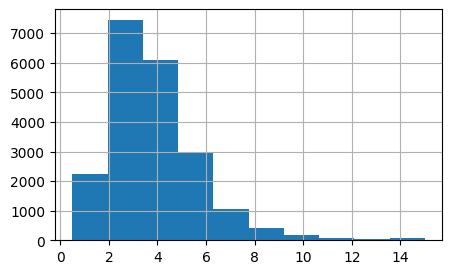

In [10]:
# check this
housing['median_income'].hist(figsize=(5,3))

train_data,test_data = train_test_split(
    housing,test_size=0.2,random_state=41,stratify=housing['median_income']
    )  

This code above is giving error, because there are some classes that only have one member (run it once to see)

In [11]:
(housing['median_income'].value_counts()==1).sum()
# Total 9694 values that are unique

np.int64(9694)

In [12]:
# Hence, create bins in which we can categories the incomes
housing['income_cat'] = pd.cut(
    housing['median_income'],
    bins = [0,1.5,3,4.5,6,np.inf],
    labels=[1,2,3,4,5]
    )
housing['income_cat'].value_counts()

income_cat
3    7236
2    6581
4    3639
5    2362
1     822
Name: count, dtype: int64

In [13]:
housing['income_cat']

0        5
1        5
2        5
3        4
4        3
        ..
20635    2
20636    2
20637    2
20638    2
20639    2
Name: income_cat, Length: 20640, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

what does it mean?  
We have created 5bins that are labelled as 1,2,3,4,5  
First interval: from 0.0 (inclusive) up to 1.5 (by default, right=True makes the right edge inclusive).  
Second interval: from 1.5 up to 3.0.  
Third interval: from 3.0 up to 4.5.  
Fourth interval: from 4.5 up to 6.0.  
Fifth interval: from 6.0 up to infinity (np.inf covers any value beyond 6.0).  

<Axes: >

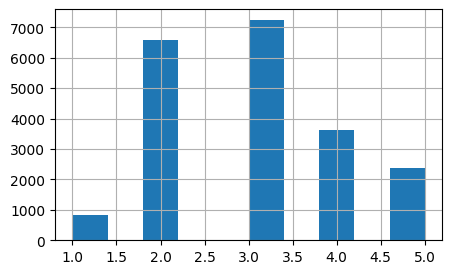

In [14]:
housing['income_cat'].hist(figsize=(5,3))

In [15]:
strat_train_data,strat_test_data = train_test_split(housing,test_size=0.2,random_state=42,stratify=housing['income_cat'])

In [16]:
# Understanding the positive difference by using stratify rather than random

def value_count_proportion(data):
    return data['income_cat'].value_counts()/len(data)

train_data, test_data = train_test_split(housing,test_size=0.2,random_state=42)

compare_proportions = pd.DataFrame({
    'original' : value_count_proportion(housing),
    'random' : value_count_proportion(test_data),
    'strated' : value_count_proportion(strat_test_data)
}).sort_index()

compare_proportions['Rand %err'] = compare_proportions['random'] * 100 / compare_proportions['original'] - 100 
compare_proportions['Strat %err'] = compare_proportions['strated'] * 100 / compare_proportions['original'] - 100

In [17]:
compare_proportions

,original,random,strated,Rand %err,Strat %err
income_cat,,,,,
1,0.039826,0.040213,0.039971,0.973236,0.364964
2,0.318847,0.324370,0.318798,1.732260,-0.015195
3,0.350581,0.358527,0.350533,2.266446,-0.013820
4,0.176308,0.167393,0.176357,-5.056334,0.027480
5,0.114438,0.109496,0.114341,-4.318374,-0.084674


In [18]:
# Now remove the 'income_cat' coloumn we dont need it anymore

for set_ in (strat_test_data,strat_train_data):
    set_.drop('income_cat',axis=1,inplace=True)

#### ___Data Visualization___

In [19]:
housing = strat_train_data.copy()

Text(0.5, 1.0, 'Understanding population distribution and median house value')

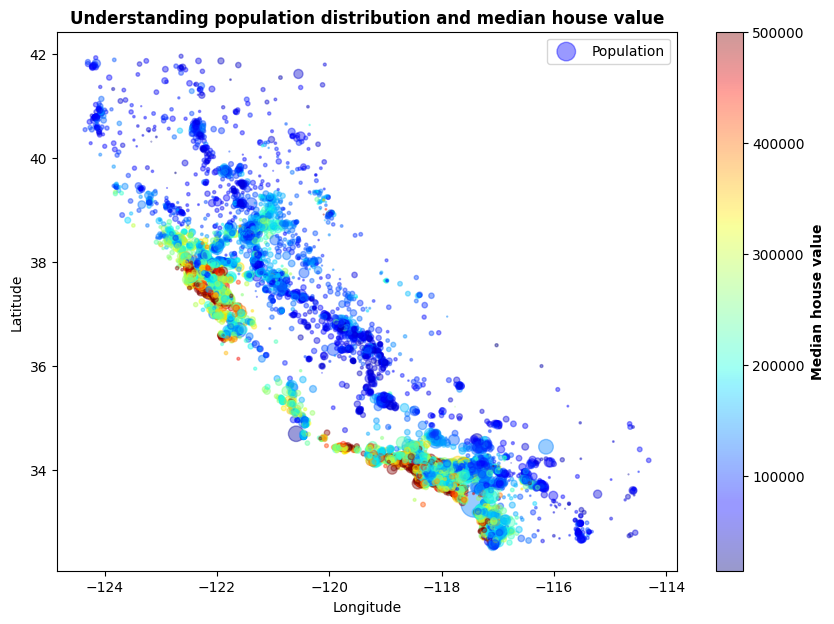

In [20]:
plt.figure(figsize=(10,7))

plt.scatter(
    x=housing['longitude'],
    y=housing['latitude'],
    s=housing['population']/100,
    c=housing['median_house_value'],
    alpha = 0.4,
    cmap='jet',
    label='Population'
    )

plt.colorbar().set_label('Median house value',fontsize=10,fontweight='bold')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Understanding population distribution and median house value',fontweight='bold')

Text(0.5, 1.0, 'Understanding population distribution and median house value')

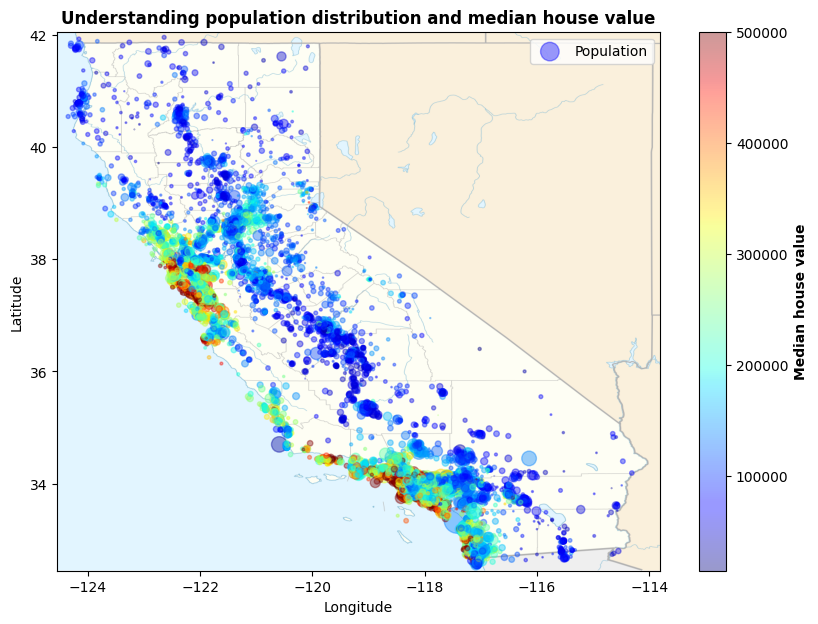

In [21]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,7))

plt.scatter(
    x=housing['longitude'],
    y=housing['latitude'],
    s=housing['population']/100,
    c=housing['median_house_value'],
    alpha = 0.4,
    cmap='jet',
    label='Population'
    )
plt.colorbar().set_label('Median house value',fontsize=10,fontweight='bold')

img = mpimg.imread(r'C:\Users\Arun\Documents\Documents\Machine_Learning\zimages\USA_California_location_map.svg.png')
plt.imshow(
    img,
    extent=[-124.55, -113.80, 32.45, 42.05],     #extent of image is given by coordinates of map (see longitude and latitude)
    alpha=0.5)


plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Understanding population distribution and median house value',fontweight='bold')


_California housing prices_: red is expensive, blue is cheap, larger circles indicate areas with a larger population

__Insights__:   
Low-population coastal areas → high house prices  
High-population coastal areas → medium to low prices  
Inland areas → low population and low prices

___Correlation___ : 
_standard correlation coefficient (also called Pearson’s r)_ gives a measure of how a two features are related.  

+1 => linear relationship (A↑ and B↑ or A↓ and B↓)  
0 => Non linear relationship (relationship is not linear, may be some other kind of relationship)  
-1 => Negative linear relationship (A↑ and B↓ or A↓ and B↑)  

Chart of all kind of scatterplot for all correlations

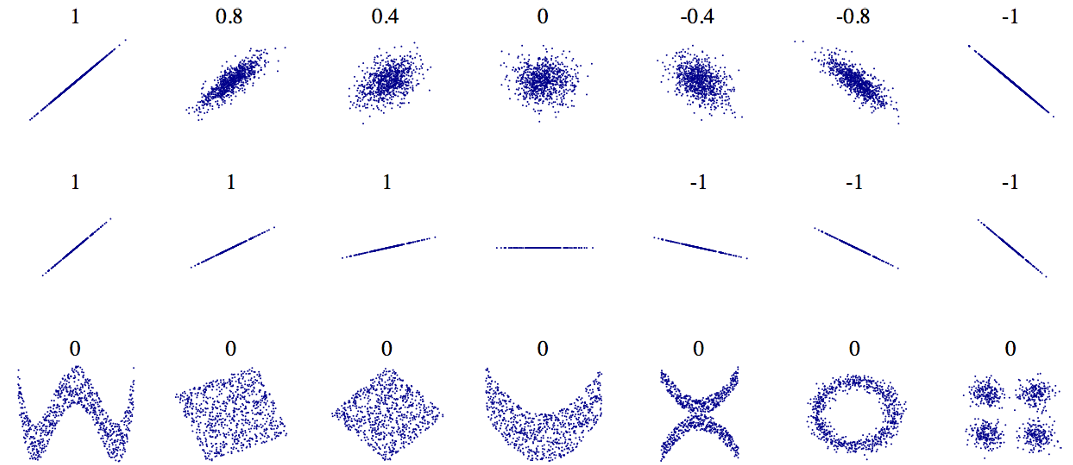

Notice that:   
slope has nothing to do with corr (in row2)  
corr=0 doesnt mean feature are independent

In [22]:
corr_matrix = housing.drop('ocean_proximity',axis=1).corr()

In [23]:
# We are only interested in correlation of 'median_house_value' to other features
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

__Notice that__:  
meadian_income has strong positive correlation with house value  
latitude has negative correlation i.e as we go north the house value decreases

 ___Using Scatter_matrix to plot all relationships___

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>,
        <Axes: xlabel='total_rooms', ylabel='median_house_value'>,
        <Axes: xlabel='latitude', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>,
        <Axes: xlabel='total_rooms', ylabel='median_income'>,
        <Axes: xlabel='latitude', ylabel='median_income'>],
       [<Axes: xlabel='median_house_value', ylabel='total_rooms'>,
        <Axes: xlabel='median_income', ylabel='total_rooms'>,
        <Axes: xlabel='total_rooms', ylabel='total_rooms'>,
        <Axes: xlabel='latitude', ylabel='total_rooms'>],
       [<Axes: xlabel='median_house_value', ylabel='latitude'>,
        <Axes: xlabel='median_income', ylabel='latitude'>,
        <Axes: xlabel='total_rooms', ylabel='latitude'>,
        <Axes: xlabel='latitude', ylabel='l

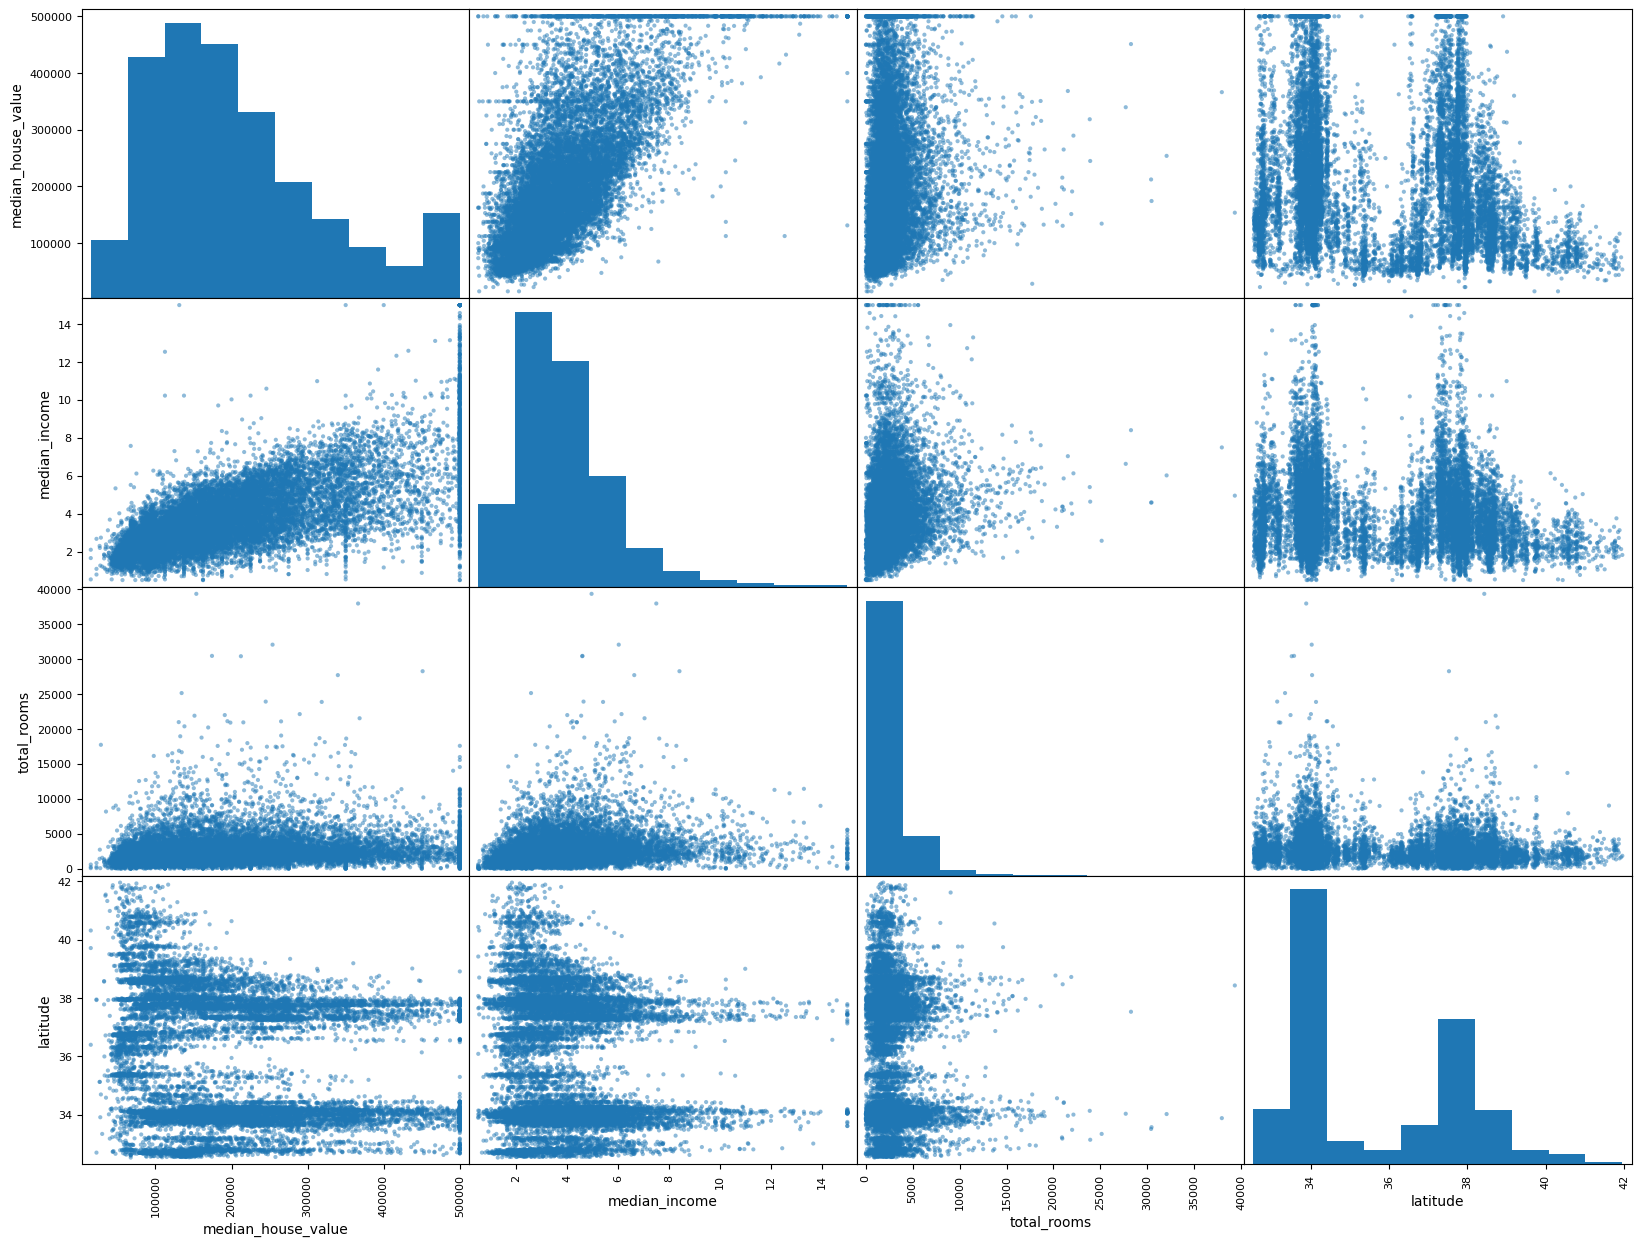

In [24]:
attributes = ['median_house_value','median_income','total_rooms','latitude']
scatter_matrix(housing[attributes],figsize=(20,15))

- Notice the linear relationship between median-house-value and median-income

<Axes: xlabel='median_income', ylabel='median_house_value'>

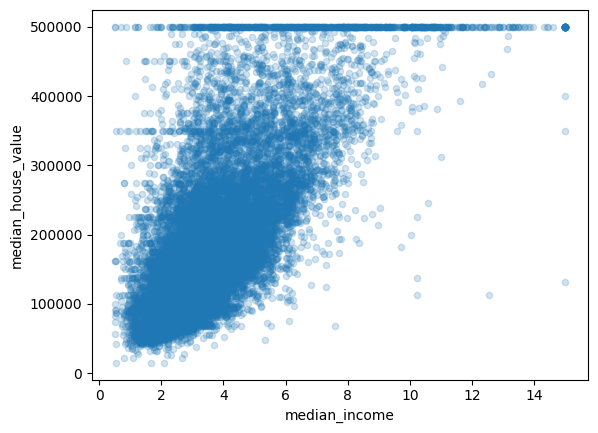

In [25]:
housing.plot(kind='scatter',y='median_house_value',x='median_income',alpha=0.2)

Notice that -   
There is a cap (upper limit- values dont go above that) at $500000, and few more below it, for ex: see slightly above 200000.....

##### ___Attribute combination___
We have seen mutliple patterns in the data but we can observe more by removing unneccessary features by creating new features that are better correlated with target

In [26]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN


_Here rather than total-rooms, total-bedrooms, or population (That is of whole district) we can use total-rooms per household, total-bedrooms per household, or population perhousehold_

In [27]:
housing['rooms_per_house'] = housing['total_rooms']/housing['households']
housing['bedroooms_per_house'] = housing['total_bedrooms']/housing['households']
housing['population_per_house'] = housing['population']/housing['households']

In [28]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_house,bedroooms_per_house,population_per_house
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND,5.485836,1.128895,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN,6.927083,1.113281,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND,5.393333,1.033333,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN,3.886128,1.074534,1.859213
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN,6.096552,1.113793,3.167241


In [29]:
corr_matrix = housing.drop('ocean_proximity',axis=1).corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value      1.000000
median_income           0.687151
rooms_per_house         0.146255
total_rooms             0.135140
housing_median_age      0.114146
households              0.064590
total_bedrooms          0.047781
population_per_house   -0.021991
population             -0.026882
bedroooms_per_house    -0.043349
longitude              -0.047466
latitude               -0.142673
Name: median_house_value, dtype: float64

Note that:
- rooms-per-house,bedrooms-per-house and population-per-house are more correlated to median-house-value

### __Prepare the Data for Machine Learning Algorithms__

___Note___  
We gonna make functions of these transformations so that:  
- we can reuse them easily in any other project
- we can use that on any dataset any number of times, hence choose the best transformation 

In [30]:
## Again copy the data set, remember to split the dataset into features and label 
# This is cuz we dont want the same transformation to apply on labels 

housing = strat_train_data.drop('median_house_value',axis=1)    #We did not use .copy() here cuz .drop() itself returns a copy of orignal df
housing_label = strat_train_data['median_house_value'].copy()

In [31]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 12655 to 19773
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16354 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


#### ___Handling Missing Values___

There are 3 ways : 
1. Drop the attribute
2. Drop the corresponding instances where values are missing
3. Replace the missing values with 0,mean,median,mode etc 

we can use `.drop`,`.dropna`,`.fillna` to do them

In [32]:
import pandas as pd

In [33]:
# But we gonna use 
from sklearn.impute import SimpleImputer

# Create instance of SimpleImputer
impute = SimpleImputer(strategy='median')   

# SimpleImputer works only for numeric data, hence remove 'ocean proximity'
housing_num = housing.drop('ocean_proximity',axis=1)

# fit the imputer, i.e We provide the data to imputer for calculations (here meadian) of each feature        
impute.fit(housing_num)

SimpleImputer(strategy='median')

In [34]:
impute.statistics_      # All those calculations(median) is stored in .statistics_ 

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [35]:
housing_num.median()   # See that, these both equal

longitude             -118.51000
latitude                34.26000
housing_median_age      29.00000
total_rooms           2119.00000
total_bedrooms         433.00000
population            1164.00000
households             408.00000
median_income            3.54155
dtype: float64

In [36]:
# Transform the data : After 'fit' has computed the calculation (median), 'transform' will replace all the missing value according to that (it doesnt re-evaluate)
X = impute.transform(housing_num)
# Returns numpy.array

# convert into dataframe
housing_tr = pd.DataFrame(X,columns=housing_num.columns,index=housing_num.index)

In [37]:
# check
housing_num['total_bedrooms'].isna().sum()

np.int64(158)

In [38]:
housing_tr['total_bedrooms'].isna().sum()

np.int64(0)

But why we used `SimpleImputer`? 
cuz it can store median (or mean etc) for each numerical feature in the dataset, hence we dont have to individually do that and fit-transform each feature

#### __Handling Text and Categorical Attributes__

In [39]:
## We have only one categorical attribute 'ocean proximity'
housing['ocean_proximity'].head(10)

12655        INLAND
15502    NEAR OCEAN
2908         INLAND
14053    NEAR OCEAN
20496     <1H OCEAN
1481       NEAR BAY
18125     <1H OCEAN
5830      <1H OCEAN
17989     <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object

In [40]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     7277
INLAND        5262
NEAR OCEAN    2124
NEAR BAY      1847
ISLAND           2
Name: count, dtype: int64

In [41]:
# We using one-hot-encoding since its considered as nominal data (see about this in EDA and FE repo)
from sklearn.preprocessing import OneHotEncoder

encode = OneHotEncoder() # create instance, (Can se sparse=False to get array directly)

encoded_arr = encode.fit_transform(housing[['ocean_proximity']]).toarray()     
# Note: 1. Returns Sparse matrix dont forget to 'convert as array' OR do 'Sparse=False' , 2. Takes 2D array/Df 

In [42]:
encoded_arr

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], shape=(16512, 5))

In [43]:
housing_OHE = pd.DataFrame(encoded_arr,columns=encode.get_feature_names_out())
housing_OHE
# Can concatenate this with original housing data

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
16507,1.0,0.0,0.0,0.0,0.0
16508,0.0,1.0,0.0,0.0,0.0
16509,1.0,0.0,0.0,0.0,0.0
16510,1.0,0.0,0.0,0.0,0.0


In [44]:
encode.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Note: Why is it considered as nominal data, when we can clearly see that districts that are near ocean have high median-price-value?   
Yes, ocean_prox affects the label(output), but the categories of ocean_prox (Ex: <1H OCEAN) does not inherent any order between themselves, they are only indicating location of district  
eg: '<1H ocean' is not bigger/smaller than 'ISLAND' like '3 inch' is smaller than '6 inch'

#### ___Creating our own Transformer___
Refer '3_Sklearns_design.ipyb'  

Sklearn follows principle of 'consistency'   
It provides Transformers for various operation but......for certain tasks we have to make our own sometimes (eg, custom cleanup operations or combining attributes)  
And it provides very easy way for that  
- Sklearn works on ___duck typing___ rather than traditional 'inheritance' (in oops)
duck typing - "If it looks like a duck and quacks like a duck, it must be a duck"
- A transformer consists three fundamental methods fit(),transform() and fit_transform(), so if our transformer contains them, sklearn will treat it like a transformer itself and work seamlessly with sklearn pipeline

In [45]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN


In [46]:
col_names = ['total_rooms','total_bedrooms','population','households']
rooms_ix,bedrooms_ix,population_ix,households_ix = [
    housing.columns.get_loc(c) for c in col_names # equal to = 3,4,5,6
]                                                 # 'ix' = index, eg: rooms is at 3rd index of columns

rooms_ix,bedrooms_ix,population_ix,households_ix

(3, 4, 5, 6)

About BaseEstimator and TransformerMixin:  
These two classes in sklearn.base that helps in creating transformer that works seamlessly with sklearn  
`BaseEstimator` gives two special methods get_params,set_params (we'll see later)  
`TransformerMixin` give fit_transform() method by itself so we dont have to create it ourself

In [47]:
from sklearn.base import BaseEstimator,TransformerMixin

#Creating a Transformer that will add few more features in original data
class CombinedAttributesAdder(BaseEstimator,TransformerMixin):
    def __init__(self,add_bedrooms_per_room=True):    # Dont use "*args","**kwargs" that doesnt work with BaseEstimator
        # Note: we aint using super.__init__() as we used to do in inheritance cuz it doesnt have anything we need in our constructor, it has things that we need in methods
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self,X,y=None):   # X=data, y=label (here no need so 'None')
        return self
    # This doesnt do anything here, cuz we dont need any statistical calclation here 
    
    def transform(self,X):
        rooms_per_household = X[:,rooms_ix]/X[:,households_ix]
        bedrooms_per_houshold = X[:,bedrooms_ix]/X[:,households_ix]
        population_per_household = X[:,population_ix]/X[:,households_ix]

        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedrooms_ix]/X[:,rooms_ix]
            return np.c_[X,rooms_per_household,bedrooms_per_houshold,population_per_household,bedrooms_per_room]
        else:
            return np.c_[X,rooms_per_household,bedrooms_per_houshold,population_per_household]
        
        # Note: The data we feed this is 'array' 
        

In [48]:
att_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)

housing_w_xtra_att = pd.DataFrame(att_adder.fit_transform(housing.values),columns=list(housing.columns)+['rooms_per_household','bedrooms_per_houshold','population_per_household'],index=housing.index)
housing_w_xtra_att

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_houshold,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,5.485836,1.128895,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,6.927083,1.113281,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.875,INLAND,5.393333,1.033333,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,3.886128,1.074534,1.859213
20496,-118.7,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,6.096552,1.113793,3.167241
...,...,...,...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.09,<1H OCEAN,6.658342,1.22977,2.023976
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,INLAND,5.571932,1.002821,3.363188
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,<1H OCEAN,4.110465,0.965116,2.662791
19140,-122.7,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,<1H OCEAN,6.297405,1.157685,2.411178


In [49]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000
mean,-119.575635,35.639314,28.653404,2622.539789,534.914639,1419.687379,497.011810,3.875884
std,2.001828,2.137963,12.574819,2138.417080,412.665649,1115.663036,375.696156,1.904931
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566950
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1164.000000,408.000000,3.541550
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.000000,602.000000,4.745325
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100


#### ___Feature Scaling___
ML algorithms usually do not perform well for highly spreaded data (data with very different scales).
For ex: the total number of rooms ranges from 6-39,320, while the median incomes only range from 0-15
##### Hence we use 2 techniques: `Normalization` Or `Standardization`
- Normalization (min-max scaling) : We do scaling by shifting the values and rescaling them, so that they have range of 0-1.  
Formula used: 

 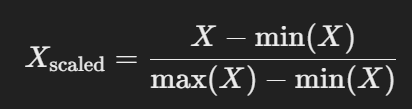


- Standardization : Rescaling the values such that the distribution has mean=0, variance=1  

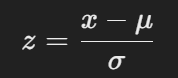

When to use which one?  
Normalization, when you want your data to have a fixed range.   
use `MinMaxScaler` for this. Also, we can change the range form 0-1 to something else by hyperparameter 'feature_range' 


Standarization, when you want your data to follow normal distribution, Ml algo works better if data is centered and have standardize variance  
use `StandardScaler` for this 

note: Standardization scales data using the mean and standard deviation, making it less sensitive to extreme outliers. For example, if one district has an income of 100 while others range from 0–15, standardization won’t compress the majority of the data into a tiny range, unlike min-max scaling.

In [50]:
from sklearn.preprocessing import StandardScaler   #Cuz we dont want values to be with just 0-1

### _Transformation Pipeline_
Transformation pipeline is the sequence of data processing steps. Each step is an estimator/transformer that fits/transforms the data, while the last step must be an transformer 

All the transformation needs to happen in a right sequence 

In [51]:
from sklearn.pipeline import Pipeline    # This is used to define the pipeline for numerical features


num_pipe = Pipeline(
    [("imputer",SimpleImputer(strategy='median')),          # list of transformers is given
    ("att_adder",CombinedAttributesAdder()),                # tuple:(name of step, transformer/estimator)
    ("std_scaler",StandardScaler())]
)

housing_num_tr = num_pipe.fit_transform(housing_num)

Note: 
- num_pipe has the same methods that the last transformer have (here StandardScaler)
- If we call fit() method on num_pipe, it will sequetially call fit_transform() on every step, passing the output to next transformer. When it reaches the last step it will then call fit() only (cuz thats what we asked for)

##### Pipeline for numerical as well as categorical data - ColumnTransformer


In [52]:
from sklearn.compose import ColumnTransformer

num_att = list(housing_num)
cat_att = ['ocean_proximity']


final_pipe = ColumnTransformer([
    ("num",num_pipe,num_att),
    ("cat",OneHotEncoder(),cat_att)
])


final_housing = final_pipe.fit_transform(housing)

There is one more method to do the same as ColumnTransformer: that is FeatureUnion
but we only gonna use ColumnTransformer since its more flexible and easy to use

In [53]:
final_housing

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]], shape=(16512, 17))

## Preprocessing Done!!!

### ___Select And Train Model___

- ##### _Linear Regression_

In [54]:
## LinearRegression
from sklearn.linear_model import LinearRegression

linear_Reg = LinearRegression()
linear_Reg.fit(X = final_housing , y = housing_label)        #Fed the data and assigned the label


LinearRegression()

In [55]:
#Testing the model
some_data = housing.iloc[:5]
some_labels = housing_label.iloc[:5]

some_data_prepared = final_pipe.transform(some_data)          #predicting some_data
# Note : 
# During training → Use fit_transform() on the training set.
# During inference (making predictions) → Use transform() on new data.

In [56]:
#predict the output
print("Prediction: ", linear_Reg.predict(some_data_prepared))

Prediction:  [ 85003.70568884 305835.41063049 152040.60989759 186689.77959128
 243115.0373748 ]


In [57]:
#Compare 
print("Original price:\n",some_labels)

Original price:
 12655     72100.0
15502    279600.0
2908      82700.0
14053    112500.0
20496    238300.0
Name: median_house_value, dtype: float64


In [58]:
error = ((linear_Reg.predict(some_data_prepared)-some_labels)/some_labels)*100
print("%age error\n",error)

#Thats a lot

%age error
 12655    17.896957
15502     9.383194
2908     83.845961
14053    65.946471
20496     2.020578
Name: median_house_value, dtype: float64


In [59]:
# Computing error in the whole model - RSME (root mean squared error)
from sklearn.metrics import root_mean_squared_error

lin_reg_prediction = linear_Reg.predict(final_housing)       #predicting all instances

rmse = root_mean_squared_error(
    y_true=housing_label,
    y_pred=lin_reg_prediction
    )

rmse

68226.27036520795

68226$ is a big error

what can we do now?
1. Reduce constraints (regularization)
2. Provide better features (do feature engineering and transformations)
3. Use more powerfull model 

- #### _Decision Tree Regressor_

In [60]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(final_housing,housing_label)

DecisionTreeRegressor()

In [61]:
# Prediction
Decision_tree_prediction = tree_reg.predict(final_housing)

In [62]:
# Error (RMSE)
rmse = root_mean_squared_error(housing_label,Decision_tree_prediction)
rmse

0.0

wait!... ZERO?? demn

##### _Cross validation_
- Train-Test Split: The dataset is divided into two parts—typically, a larger portion (e.g., 80%) is used to train the model, and a smaller portion (e.g., 20%) is reserved for testing its performance.
- K-Fold Cross Validation: The dataset is split into k equal parts (folds); in each of k iterations, one fold serves as the validation set (roughly 1/k of the data) while the remaining k–1 folds are used for training, and the results are averaged to evaluate model performance.

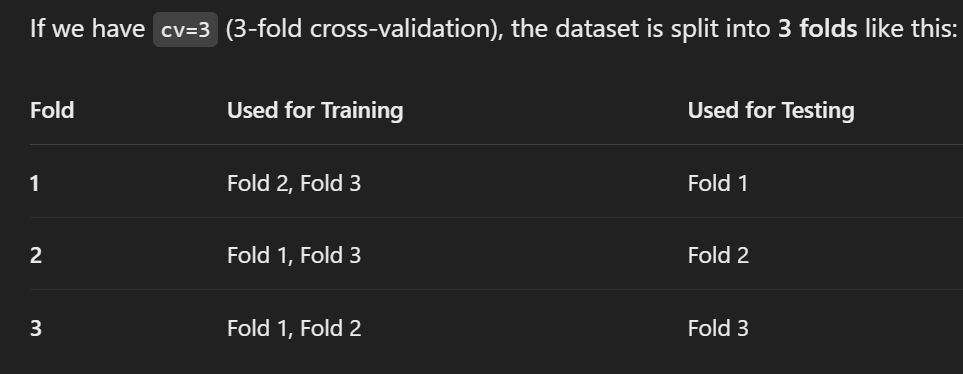

In [63]:
# Using k-fold cross validation
from sklearn.model_selection import cross_val_score

decision_tree_scores = cross_val_score(
    tree_reg,                                 #Estimator 
    final_housing,                            #Preprocessed data
    housing_label,                            #labels (actual output)
    scoring="neg_root_mean_squared_error",    #error to be calulated
    cv = 10                                   #Number of folds
    )

# Note: acc to sklearn, higher the value -> better the performance
#       acc to rmse, lower the value -> better the performance 
# Hence we have to get 'negative_root_mean_squared_error' as scoring

In [64]:
# Showing error:

def display_scores(scores):
    scores = -scores
    print("scores\n",scores)
    print("Mean :", scores.mean())
    print("Variance :",scores.var())
    print("std dev :",scores.std())


display_scores(decision_tree_scores)

scores
 [72169.28735919 70767.31148529 69315.20533515 73195.33418282
 70767.74855235 76165.65051918 74891.90072358 73588.45660599
 69211.7707735  73583.43816167]
Mean : 72365.61036987213
Variance : 4888728.665341487
std dev : 2211.046961360497


In [65]:
# Comparing this with same k-cross validation by linear regression
lin_reg_scores = cross_val_score(
    linear_Reg,
    final_housing,
    housing_label,
    scoring='neg_root_mean_squared_error',
    cv = 10
)

In [66]:
display_scores(lin_reg_scores)

scores
 [71625.67377548 63824.3149072  66942.50177967 68455.48845795
 66975.17768707 72461.80947879 70731.74656469 68391.47537716
 65954.62840132 69733.79772298]
Mean : 68509.66141523208
Variance : 6507337.734361064
std dev : 2550.9483990000786


_There are three types of cross validation usually used_
- K-fold cv  :  k-1 number of sets are used for training and 1 set for validation
- Stratified k-fold cv : folds are divided based on stratization (stratified data so that each fold contain approx equal ratio of different target labels)
- Time series cv : here the data till current time is used for training and future for prediction/validation

##### __Concept of `overfitting` and `underfitting`__

The model is said to be overfit if it is so complex and learns not only all the patterns in the data but also noise in the data...Hence overfit models only work on training set but fail to generalize on new data

The model is said to be underfit if it is too simple to understand patterns and structures of data...
Hence underfit models do not fail on training set as well as new data

clearly.... LinearRegression is underfit and DecisionTreeRegressor is overfit (if we have to choose between them, linearRegression clearly wins here)

- #### ___RandomForestRegressor___
Random Forests work by training many Decision Trees on random subsets of
the features, then averaging out their predictions. Building a model on top of many
other models is called Ensemble Learning

In [67]:
from sklearn.ensemble import RandomForestRegressor

rand_forest = RandomForestRegressor(n_estimators=25)    # by default n_estimators=100, that can take fking long time
rand_forest.fit(final_housing,housing_label)                      

rand_forest_prediction = rand_forest.predict(final_housing)

In [68]:
#Error
frst_rsme = root_mean_squared_error(housing_label,rand_forest_prediction)
frst_rsme

20060.640733671808

In [69]:
# Checking scores
random_forest_scores = cross_val_score(
    rand_forest,
    final_housing,
    housing_label,
    scoring='neg_root_mean_squared_error',
    cv = 4
)
display_scores(random_forest_scores)

KeyboardInterrupt: 

### _Trained parameter and Hyperparameter_

__Trained parameter (model parameter)__ : These are the values that are learned from training data. These change by themselves according to training data as model fits the data 

__Hyperparameter__ : values that we assign to the model manually.

eg. coefficients(weights) and intercept in linear_regression are trained parameter  
eg. n_estimators,n_jobs in randomforestregressor and feature_range in minmaxscaler are hyperparameter

- #### ___Support vector regression (from Support Vector Machines (SVM))___


In [ ]:
from sklearn.svm import SVR

svm_reg = SVR(kernel='linear')
svm_reg.fit(final_housing,housing_label)

svm_prediction = svm_reg.predict(final_housing)

svm_rmse = root_mean_squared_error(housing_label,svm_prediction)
print(svm_rmse)

111059.66723245305


In [ ]:
svm_scores = cross_val_score(svm_reg,final_housing,housing_label,scoring='neg_root_mean_squared_error',cv=3)
display_scores(svm_scores)

scores
 [112135.24961895 113917.27204447 114535.7686311 ]
Mean : 113529.43009817094
Variance : 1035625.9422716806
std dev : 1017.6570848137798


### _Saving the model_ 
1. pickel module
2. joblib module (better)

In [ ]:
import joblib
# This module lets you save any python object as a file 
# We are saving our models as file

In [ ]:
joblib.dump(linear_Reg,'linear_regression_model.pkl')
joblib.dump(tree_reg,'decision_tree_regression_model.pkl')
joblib.dump(rand_forest,'Random_forest_model.pkl')
joblib.dump(svm_reg,'svm_regression_model.pkl')

['svm_regression_model.pkl']

In [ ]:
# later to get these models, we gonna write 
# "my_model_loaded = joblib.load("my_model.pkl")"

#### _Fine tuning (improving) the model_
several techniques for this
- Grid search : search the best combination hyperparameters for the model
- Ensemble models : here we combine the models that are performing well, especially when models have very different types of errors. The models combined are called _ensemble_ 

##### ___Grid Search___ 
Once we get a promising model, we have to choose about what hyperparameter combinations are best.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False                     #Total 12+6=18 combinations
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]
# Will learn later about what these hyperparameters actually are


forst_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    forst_reg,                                 # Estimator
    param_grid,                                # the grid (that will form combinations to experiment)
    scoring='neg_root_mean_squared_error',     # computing error
    cv=5,                                      # 5 folds for cross-validation          
    return_train_score=True                    # cuz we want to check the score later
)

# Now, training all those combinations on the data
grid_search.fit(final_housing,housing_label)             # 18*5(no. of folds)=90 rounds of training and evaluation

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

GridSearchCV systematically tries each hyperparameter combination by training the model, evaluating its performance via cross-validation, and then comparing the scores to return the optimized set of hyperparameters.

In [ ]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [ ]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30, random_state=42)

In [ ]:
# Check score
cross_validation_results = grid_search.cv_results_
pd.DataFrame(cross_validation_results)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.135011,0.022156,0.005693,0.000544,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-66241.082064,-63148.875310,...,-65879.659658,1659.072031,18,-33667.122910,-33862.404571,-34022.118585,-34307.466308,-34903.947451,-34152.611965,430.217005
1,0.490884,0.071111,0.016237,0.003927,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-55699.678530,-55168.730553,...,-56380.665230,1140.685793,11,-24067.251251,-24674.497705,-24647.732478,-24749.329999,-25061.311489,-24640.024584,322.101670
2,1.500296,0.207210,0.048229,0.010457,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-53065.892099,-52584.549769,...,-53301.761833,828.424782,9,-20794.028269,-21209.592163,-20847.721628,-20977.723619,-21041.383802,-20974.089896,147.237305
3,0.267618,0.033669,0.006608,0.001381,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-61115.547876,-59910.577937,...,-60547.710974,686.765664,15,-32198.257288,-32450.021414,-32306.897555,-31399.932206,-31620.186998,-31995.059092,409.933786
4,0.789492,0.059562,0.019387,0.005449,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-52832.195233,-51602.735182,...,-52876.182550,843.661375,7,-22709.312298,-23316.601397,-23034.781042,-23075.895326,-23244.510495,-23076.220112,210.923428
5,2.386373,0.175053,0.043103,0.005505,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-51095.297104,-49660.179465,...,-50669.829398,1004.161990,3,-19784.499383,-20067.881400,-19875.242734,-19852.937447,-19890.991550,-19894.310503,94.097464
6,0.343755,0.024362,0.006246,0.001101,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-60465.656319,-58742.877463,...,-59286.372583,1014.363142,12,-30549.820649,-30597.698169,-30551.818737,-29534.772444,-30147.287237,-30276.279447,405.099570
7,1.118392,0.129769,0.015635,0.001181,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-51831.901969,-51509.971306,...,-51853.371569,227.554599,5,-22176.472674,-22797.192177,-22443.586286,-22099.789159,-22648.643262,-22433.136711,266.865385
8,3.983010,0.278574,0.059025,0.002559,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-49965.091153,-49624.507972,...,-49953.142256,588.846017,1,-19390.223910,-19775.411656,-19613.950621,-19232.794171,-19595.314902,-19521.539052,189.236015
9,0.521917,0.011090,0.007527,0.000622,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-60057.649722,-58450.845256,...,-60242.729220,1060.127946,13,-30885.381884,-31576.124130,-30832.967200,-30616.116743,-29967.188698,-30775.555731,516.748618


In [ ]:
pd.DataFrame(cross_validation_results)[['mean_test_score','params']]

,mean_test_score,params
0,-65879.659658,"{'max_features': 2, 'n_estimators': 3}"
1,-56380.665230,"{'max_features': 2, 'n_estimators': 10}"
2,-53301.761833,"{'max_features': 2, 'n_estimators': 30}"
3,-60547.710974,"{'max_features': 4, 'n_estimators': 3}"
4,-52876.182550,"{'max_features': 4, 'n_estimators': 10}"
5,-50669.829398,"{'max_features': 4, 'n_estimators': 30}"
6,-59286.372583,"{'max_features': 6, 'n_estimators': 3}"
7,-51853.371569,"{'max_features': 6, 'n_estimators': 10}"
8,-49953.142256,"{'max_features': 6, 'n_estimators': 30}"
9,-60242.729220,"{'max_features': 8, 'n_estimators': 3}"


observe that "49953.142255500985 {'max_features': 6, 'n_estimators': 30}" is minimum

In summary: Grid search is used for searching the best combination of hyperparameters for a model.  
eg. tell about how many estimators there should be used in randomforest or whether to add add_bedrooms_per_room in CombinedAttributesAdder

#### ___Randomized Search___

In RandomizedSearchCV, we define a range of possible values for each hyperparameter. The algorithm randomly selects different combinations from these ranges, trains and evaluates the model for each combination, scores them, and identifies the best-performing model.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint        

rand_params = [
    {'n_estimators':randint(1,30),
    'max_features':randint(1,8)}
]

randomizedd_forest_reg = RandomForestRegressor(random_state=42)

rand_search = RandomizedSearchCV(
    randomizedd_forest_reg,
    rand_params,
    scoring='neg_root_mean_squared_error',
    cv=4,
    n_iter=10,                                  #10 iterations i,e 10 random combinations from dict
    return_train_score=True)

rand_search.fit(final_housing,housing_label)

RandomizedSearchCV(cv=4, estimator=RandomForestRegressor(random_state=42),
                   param_distributions=[{'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000029F1BC14510>,
                                         'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000029F1ED58690>}],
                   return_train_score=True,
                   scoring='neg_root_mean_squared_error')

In [ ]:
rand_search.best_estimator_

RandomForestRegressor(max_features=7, n_estimators=28, random_state=42)

In [ ]:
rand_search.best_params_

{'max_features': 7, 'n_estimators': 28}

In [ ]:
cv_results = rand_search.cv_results_

In [ ]:
pd.DataFrame(cv_results)[['mean_test_score','params']]

,mean_test_score,params
0,-51387.954850,"{'max_features': 5, 'n_estimators': 17}"
1,-54275.587543,"{'max_features': 7, 'n_estimators': 7}"
2,-66386.788376,"{'max_features': 1, 'n_estimators': 4}"
3,-54275.587543,"{'max_features': 7, 'n_estimators': 7}"
4,-65305.228772,"{'max_features': 4, 'n_estimators': 2}"
5,-52199.336779,"{'max_features': 4, 'n_estimators': 17}"
6,-51784.920236,"{'max_features': 3, 'n_estimators': 22}"
7,-53146.123702,"{'max_features': 7, 'n_estimators': 9}"
8,-50808.027412,"{'max_features': 7, 'n_estimators': 28}"
9,-86468.337653,"{'max_features': 2, 'n_estimators': 1}"


Simply by setting the number of iterations, you have more control over the computing budget you want to allocate to hyperparameter search.

#### _Analyse the best model and its error_

getting the best model 

In [ ]:
## Checking the importance of each feature in the best model
feature_importance = grid_search.best_estimator_.feature_importances_
feature_importance

array([8.07375568e-02, 7.08930635e-02, 4.21773965e-02, 1.74301625e-02,
       1.52374513e-02, 1.70303171e-02, 1.46427773e-02, 2.95060662e-01,
       6.91027900e-02, 2.39354784e-02, 1.02825269e-01, 8.68613063e-02,
       2.01393679e-02, 1.34188238e-01, 4.51557132e-05, 5.10850162e-03,
       4.58450613e-03])

what we gonna do?  
We gonna map these feature importance with corresponding features to analyse if we should remove some 

In [ ]:
# Getting the feature names out 

extra_att = ['rooms_per_household','bedrooms_per_houshold','population_per_household']      # The one we added later
num_att      # numerical attributes (see that we this defined when creating pipeline)


cat_encoder = final_pipe.named_transformers_['cat']

In [ ]:
cat_encoder.categories_[0]

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)

In [ ]:
cat_feature_att = list(cat_encoder.categories_[0])
cat_feature_att

['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']

In [ ]:
all_att_list = num_att + extra_att + cat_feature_att
all_att_list

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'rooms_per_household',
 'bedrooms_per_houshold',
 'population_per_household',
 '<1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN']

In [ ]:
sorted(zip(feature_importance,all_att_list),reverse=True)

[(np.float64(0.2950606624910327), 'median_income'),
 (np.float64(0.134188237622365), 'ISLAND'),
 (np.float64(0.10282526884582717), 'population_per_household'),
 (np.float64(0.0868613063186464), '<1H OCEAN'),
 (np.float64(0.08073755679282298), 'longitude'),
 (np.float64(0.07089306352650772), 'latitude'),
 (np.float64(0.06910278995029588), 'rooms_per_household'),
 (np.float64(0.04217739653113908), 'housing_median_age'),
 (np.float64(0.02393547843630484), 'bedrooms_per_houshold'),
 (np.float64(0.020139367898956644), 'INLAND'),
 (np.float64(0.017430162487471364), 'total_rooms'),
 (np.float64(0.017030317089363315), 'population'),
 (np.float64(0.015237451279387608), 'total_bedrooms'),
 (np.float64(0.014642777261462623), 'households'),
 (np.float64(0.005108501621399215), 'NEAR OCEAN'),
 (np.float64(4.515571322391608e-05), 'NEAR BAY')]

With this information, you may want to try dropping some of the less useful features
 (e.g., apparently only one ocean_proximity category is really useful, so you could try
 dropping the others).
 You should also look at the specific errors that your system makes, then try to under
stand why it makes them and what could fix the problem (adding extra features or
 getting rid of uninformative ones, cleaning up outliers, etc.).

## Done with building the model! 

### _Run the model on test_data_

In [ ]:
X_test = strat_test_data.drop('median_house_value',axis=1)
Y_test = strat_test_data['median_house_value'].copy()

# Transform the data (Do not FIT!)
final_X_test = final_pipe.transform(X_test)


estimator = grid_search.best_estimator_
final_prediction = estimator.predict(final_X_test)

In [ ]:
# RSME
test_rsme = root_mean_squared_error(Y_test,final_prediction)
test_rsme

47761.82508238121

##### __Error estimate and confidence interval__

The error we calculated (rsme) is a single value. But the true error of your model can vary in a range according to different train-test split or different data right?.

Confidence Interval : range in which a value(in our case 'error') might lie 

So we gonna calculate a 95% confidence interval  
i.e range of values that we are 95% sure rsme lies in

In [ ]:
from scipy import stats

confidence = 0.95
squared_errors = (final_prediction - Y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

# I just copy-pasted this cuz its in my statistics syllabus later (so ill learn it from book later)

array([45805.61245032, 49641.00863652])

# ___WE ARE FKING DONEEEE!!___

In [ ]:
housing.head(1)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND


In [ ]:
def predict_price(data):
    housing_transformed = final_pipe.transform(data.head(1))
    prediction = estimator.predict(housing_transformed)
    return prediction

predict_price(housing) 

array([73996.66666667])

and the original is "72100.0	"

## ___Finally___

NOTE -
1. Final Evaluation: After extensive hyperparameter tuning, your model might perform a bit better on validation data than on unseen data. Once you have a final model, use the test set to get an unbiased performance estimate. Transform the test data using your pipeline (without re-fitting) and compute error metrics.

2. Prelaunch Phase: Document your solution thoroughly—explain what worked, what didn’t, your assumptions, and limitations. Prepare clear presentations and visuals (e.g., key insights like “median income is the top predictor”) for stakeholders.

3. Deployment: Save your entire pipeline (using tools like joblib) so that you can load the model into production. You can deploy the model as a web service (via REST API or cloud platforms like Google Cloud AI Platform) to handle predictions in a scalable, load-balanced manner.

4. Monitoring and Maintenance: Once launched, continuously monitor the model’s performance. Set up alerts for drops in performance (which may indicate issues like data drift or infrastructure failures), and have processes in place to retrain and update the model as new data comes in. Also, keep backups of both models and datasets to quickly roll back if needed.

### How to see if model is reliable? 
1. Scatter plot of y_test vs y_predict is linear
2. residual = y_test - y_predict. Distribution of residuals is normal distribution
3. Scatter plot of residuals vs y_predict is randomly distributed over 0